# Stratospheric Balance

We will have a look at stratospheric balance as function of time.

In [1]:
import sys, os, glob
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)

In [2]:
import pylab as plt
import seaborn as sns
import cartopy.crs as ccrs
import importlib

sns.set_context('talk')

colors = plt.rcParamsDefault["axes.prop_cycle"].by_key()["color"]
ora = colors.pop(1)
colors.insert(2, ora)

myPara = {'figure.figsize': (14,7), 'lines.linewidth': 3, 'legend.frameon' : False,
          'axes.spines.right': False,
          'axes.spines.top': False,
          'axes.titleweight': 'bold',
          "axes.prop_cycle": plt.cycler(color=colors)
         }
                            
plt.rcParams.update( myPara )

import string

In [3]:
for pname in plt.rcParams:
    if 'linewidth' in pname:
        print( pname, plt.rcParams[pname])

axes.linewidth 1.875
boxplot.boxprops.linewidth 1.0
boxplot.capprops.linewidth 1.0
boxplot.flierprops.linewidth 1.0
boxplot.meanprops.linewidth 1.0
boxplot.medianprops.linewidth 1.0
boxplot.whiskerprops.linewidth 1.0
contour.linewidth None
grid.linewidth 1.5
hatch.linewidth 1.0
lines.linewidth 3.0
patch.linewidth 1.5


## Open Data

*Data Description*:

* ensembles are here: `/work/bb1262/data/echam-ham/wifi-aus/wifiaus_ham_long_gfas2020_injtrp+1_pcb_ao_ens`
    * ensemble data two subdirs as hierachical structure
    
* nudged data are here: `/work/bb1262/data/echam-ham/wifi-aus/wifiaus_ham_long_nu_gfas2020_injtrp+1_pcb_ao`


In [4]:
sys.path.append('../tools')

import importlib
import reader, plot, analysis
importlib.reload( reader )
importlib.reload( plot )
importlib.reload( analysis )
from analysis import ens_stat


In [5]:
d = reader.read_wifiaus_combination( file_type = 'ediag-plev', average_type = 'zonmean' )

## Analysis

* Use theta to mask lower stratosphere and do analysis

In [6]:
heat = d[['dtdt_rheat_sw', 'dtdt_rheat_lw']]

In [7]:
heat_monthly = heat.groupby('time.month').mean('time').squeeze()

In [8]:
theta = d['tpot'].sel(mode = 'fire0.0', ensemble = 'nudged',)
theta_m = theta.groupby('time.month').mean('time').squeeze()

In [9]:
heat_monthly_stats = ens_stat( heat_monthly )
heat_monthly_stats.compute()

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:        (lat: 96, plev: 50, mode: 4, month: 3, stats: 5)
Coordinates:
    lon            float64 0.0
  * lat            (lat) float64 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev           (plev) float64 1.0 4.0 11.0 ... 9.787e+04 9.918e+04 1e+05
  * mode           (mode) <U7 'fire1.0' 'fire2.0' 'fire3.0' 'fire5.0'
  * month          (month) int64 1 2 3
  * stats          (stats) <U10 'mean' 'confidence' 'upper' 'lower' 'reference'
Data variables:
    dtdt_rheat_sw  (stats, month, mode, plev, lat) float32 0.0 0.0 ... nan nan
    dtdt_rheat_lw  (stats, month, mode, plev, lat) float32 -0.0396 ... nan
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Oct 04 11:48:08 2022: cdo -zonmean -daymean -selgrid,1 ...
    frequency:    day
    CDO:          Climate Data Operators version 2.0.6 (https://mpimet.mpg.de...

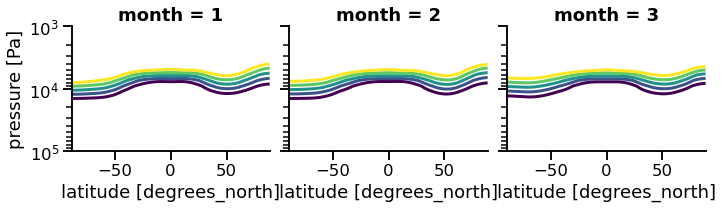

In [10]:
theta_m.plot.contour( levels = np.arange(400, 500, 20), extend = 'neither',
    x = 'lat', y = 'plev', col = 'month', yincrease = False, 
    yscale = 'log', ylim = (1000e2,10e2))


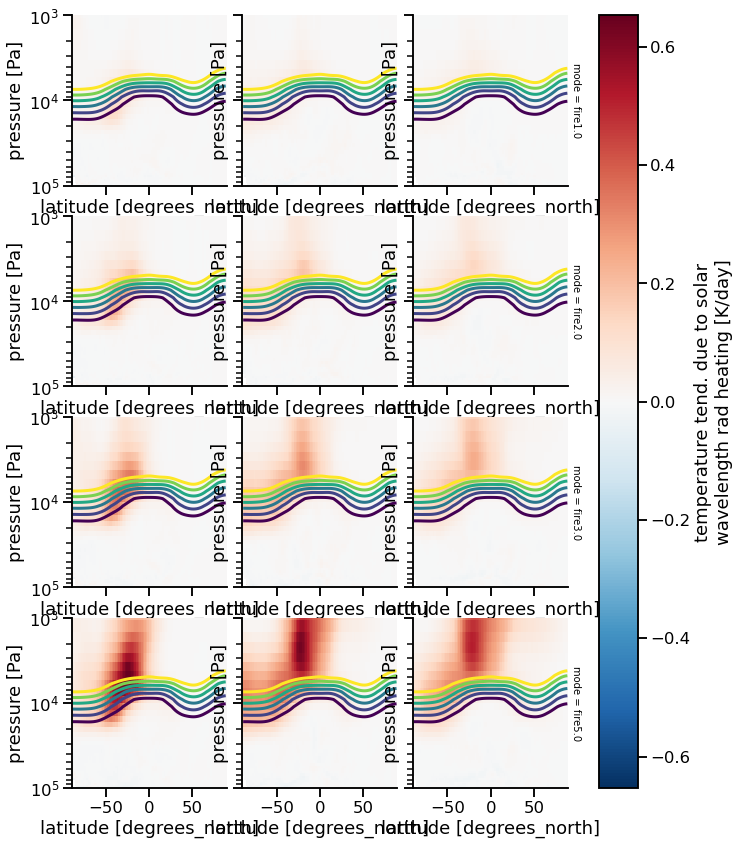

In [11]:
heat_monthly_stats['dtdt_rheat_sw'].sel(stats='mean').plot( 
    x = 'lat', y = 'plev', row = 'mode', col = 'month', yincrease = False, 
    yscale = 'log', ylim = (1000e2,10e2))

fig = plt.gcf()
axs = fig.axes

for a in axs[:-1]:
    #a.axhline(plev*1e2)
    theta_m.mean('month').plot.contour( levels = np.arange(380, 500, 20), 
                                       extend = 'neither',
    x = 'lat', y = 'plev', ax = a, yincrease = False, 
    yscale = 'log', ylim = (1000e2,10e2))
    a.set_title('')

In [12]:
theta_mask = np.logical_and(theta > 380,theta < 500)

In [13]:
d_tmask = d.where( theta_mask ).mean('plev')

In [14]:
global_heating = analysis.glob_mean( d_tmask[['dtdt_rheat_sw', 'dtdt_rheat_lw']] ).squeeze()

In [15]:
global_heating['dtdt_net'] = global_heating['dtdt_rheat_sw'] + global_heating['dtdt_rheat_lw']

* **prepare nudged data part**

In [16]:
global_heat_nudged = global_heating.sel(ensemble = 'nudged')
global_heat_nudged = global_heat_nudged.sel(mode = ['fire1.0', 'fire2.0', 'fire3.0', 'fire5.0']) - global_heat_nudged.sel(mode = 'fire0.0') 
global_heat_nudged.load()

<xarray.Dataset>
Dimensions:        (time: 91, mode: 4)
Coordinates:
  * time           (time) datetime64[ns] 2020-01-01T14:52:00 ... 2020-03-31T1...
    lon            float64 0.0
  * mode           (mode) <U7 'fire1.0' 'fire2.0' 'fire3.0' 'fire5.0'
    ensemble       <U11 'nudged'
Data variables:
    dtdt_rheat_sw  (mode, time) float64 0.01173 0.01502 ... 0.07659 0.07582
    dtdt_rheat_lw  (mode, time) float64 0.0006479 -0.00074 ... -0.1156 -0.1153
    dtdt_net       (mode, time) float64 0.01238 0.01428 ... -0.039 -0.03948

## Plotting 

In [17]:
global_heating_stats = ens_stat( global_heating )
global_heating_stats.load()

<xarray.Dataset>
Dimensions:        (time: 91, mode: 4, stats: 5)
Coordinates:
  * time           (time) datetime64[ns] 2020-01-01T14:52:00 ... 2020-03-31T1...
    lon            float64 0.0
  * mode           (mode) <U7 'fire1.0' 'fire2.0' 'fire3.0' 'fire5.0'
  * stats          (stats) <U10 'mean' 'confidence' 'upper' 'lower' 'reference'
Data variables:
    dtdt_rheat_sw  (stats, mode, time) float64 0.01401 0.01498 ... 0.3331 0.3323
    dtdt_rheat_lw  (stats, mode, time) float64 -0.0004412 -0.00089 ... -0.221
    dtdt_net       (stats, mode, time) float64 0.01357 0.01409 ... 0.1116 0.1113

In [18]:
global_heating_smooth = global_heating_stats.rolling( 
    time = 10, center = True ).mean('time')

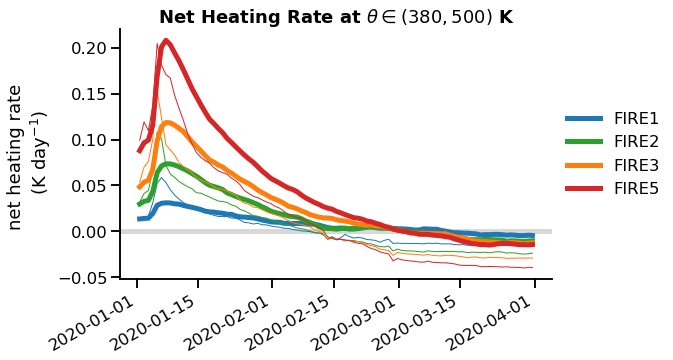

In [25]:
plt.figure( figsize = (10, 6))
plt.subplots_adjust( left = 0.2, bottom = 0.3, right = 0.8)
modes = global_heating_stats.mode
colors = ['C0', 'C1', 'C2', 'C3']
nlabels = plot.standardize_firenames( modes.data )
    
for i, mode in enumerate( modes ):
    gsn = global_heat_nudged.sel(mode = mode)
    gss = global_heating_stats.sel(mode = mode)
    
    gsn['dtdt_net'].plot( x = 'time', c = colors[i], lw = 1 ) #
    gss['dtdt_net'].sel(stats = 'mean').plot( x = 'time', c = colors[i], lw = 5, 
                                             label = nlabels[i] ) #

    
plt.legend(loc = 'center left', bbox_to_anchor=(1., 0.5,))
plt.axhline(0, color = 'gray', alpha = 0.3, zorder = 1, lw = 5 )
plt.xlabel('')
plt.ylabel('net heating rate \n (K day${}^{-1}$)')
plt.title(r'Net Heating Rate at $\theta\in(380,500)$ K')
plt.savefig('../pics/net-heating-decay-in-stratosphere.png', dpi = 600)

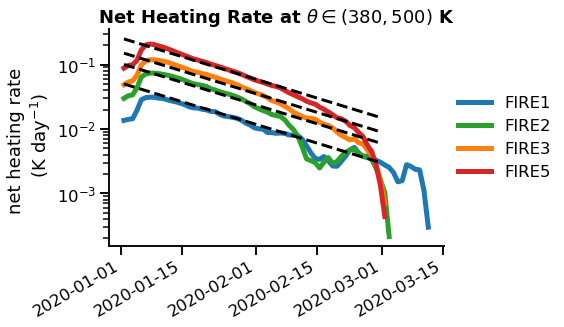

In [26]:
modes = global_heating_stats.mode
colors = ['C0', 'C1', 'C2', 'C3']

trel = (gss.time - gss.time.isel(time = 0)).astype(np.float32) / 1e9 / 3600 / 24.
decay_time = 21.

factors = np.array([1,2,3,5])
for offset in factors / 20.:
    fit = offset * np.exp(-trel/decay_time)
    fit = fit.sel(time = slice('2020-01', '2020-02'))
    fit.plot( x = 'time', color = 'k', ls = '--', zorder = 3)
    
for i, mode in enumerate( modes ):
    # gsn = global_heat_nudged.sel(mode = mode)
    gss = global_heating_stats.sel(mode = mode)
    gss = gss.where( gss > 0 )
    
    # gsn['dtdt_net'].plot( x = 'time', c = colors[i], lw = 1 ) #
    gss['dtdt_net'].sel(stats = 'mean').plot( x = 'time', c = colors[i], lw = 5, 
                                             label = nlabels[i] ) #
plt.legend(loc = 'center left', bbox_to_anchor=(1., 0.5,))
plt.axhline(0, color = 'gray', alpha = 0.3, zorder = 1, lw = 5 )
plt.xlabel('')
plt.ylabel('net heating rate \n (K day${}^{-1}$)')
plt.title(r'Net Heating Rate at $\theta\in(380,500)$ K')
plt.yscale('log')
# plt.ylim(1e-3, 3e-1)


    

(0.001, 0.3)

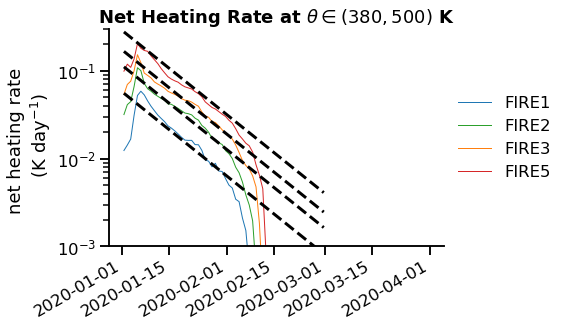

In [27]:
modes = global_heating_stats.mode
colors = ['C0', 'C1', 'C2', 'C3']

trel = (gss.time - gss.time.isel(time = 0)).astype(np.float32) / 1e9 / 3600 / 24.
decay_time = 14.

factors = np.array([1,2,3,5])
for offset in factors / 18.:
    fit = offset * np.exp(-trel/decay_time)
    fit = fit.sel(time = slice('2020-01', '2020-02'))
    fit.plot( x = 'time', color = 'k', ls = '--', zorder = 3)
    
for i, mode in enumerate( modes ):
    gsn = global_heat_nudged.sel(mode = mode)
    # gss = global_heating_stats.sel(mode = mode)
    #gsn = gsn.where( gss > 1e-4 )
    
    gsn['dtdt_net'].plot( x = 'time', c = colors[i], lw = 1, label = nlabels[i] )
    #gss['dtdt_net'].sel(stats = 'mean').plot( x = 'time', c = colors[i], lw = 5, 
                                          #
plt.legend(loc = 'center left', bbox_to_anchor=(1., 0.5,))
plt.axhline(0, color = 'gray', alpha = 0.3, zorder = 1, lw = 5 )
plt.xlabel('')
plt.ylabel('net heating rate \n (K day${}^{-1}$)')
plt.title(r'Net Heating Rate at $\theta\in(380,500)$ K')
plt.yscale('log')
plt.ylim(1e-3, 3e-1)


    

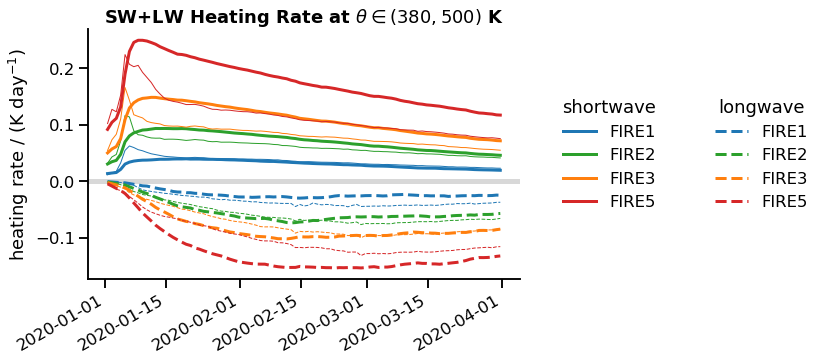

In [30]:
plt.figure( figsize = (10, 6))
plt.subplots_adjust( left = 0.2, bottom = 0.3, right = 0.8)
modes = list( global_heating_stats.mode.data )
colors = ['C0', 'C1', 'C2', 'C3']

swhandles = []

for i, mode in enumerate( modes ):
    gsn = global_heat_nudged.sel(mode = mode)
    gss = global_heating_stats.sel(mode = mode)
    
    gsn['dtdt_rheat_sw'].plot( x = 'time', c = colors[i], lw = 1 ) #
    p, = gss['dtdt_rheat_sw'].sel(stats = 'mean').plot( x = 'time', c = colors[i], lw = 3) #
    swhandles += [p, ]
    
legend1 = plt.legend(handles = swhandles, labels = nlabels,
           loc = 'center right', bbox_to_anchor=(1.35, 0.5,), title = 'shortwave')

lwhandles = []
for i, mode in enumerate( modes ):
    gsn = global_heat_nudged.sel(mode = mode)
    gss = global_heating_stats.sel(mode = mode)
    
    gsn['dtdt_rheat_lw'].plot(x = 'time', c = colors[i], 
                                                 lw = 1, ls = '--') #
    p, = gss['dtdt_rheat_lw'].sel(stats = 'mean').plot(x = 'time', c = colors[i], 
                                                  lw = 3, ls = '--', label = nlabels[i]) #

    lwhandles +=[ p, ]

legend2 = plt.legend(handles = lwhandles, labels = nlabels,
           loc = 'center right', bbox_to_anchor=(1.7, 0.5,), title = 'longwave')
plt.gca().add_artist(legend1)

#plt.legend(loc = 'center left', bbox_to_anchor=(1.33, 0.5,), title = 'longwave')
plt.axhline(0, color = 'gray', alpha = 0.3, zorder = 1, lw = 5 )
plt.xlabel('')
plt.ylabel('heating rate / (K day${}^{-1}$)')
plt.title(r'SW+LW Heating Rate at $\theta\in(380,500)$ K')
plt.savefig('../pics/sw-lw-heating-decay-in-stratosphere.png', dpi = 600)

**Take-away points:**

* after a month or two, the stratospheric adjustment let new equilibrium state in which sw forcing is balanced by lw response